# Model Explaining SB3

---
## 1. Set-Up and Prep:

In [1]:
%%capture
import numpy as np
import pandas as pd
import torch
import shap

from stable_baselines3 import DDPG
from stable_baselines3.common.env_checker import check_env

from classes import ProsumerEnv

2023-07-19 08:43:28.850792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Defining some helper methods:

In [2]:
def print_violin_plot(index, shap_values, state_df):
    shap_values_np_arr = np.array(shap_values[index])

    shap.plots.violin(shap_values = shap_values_np_arr, features = state_df)

In [3]:
def print_scatter_plot(action_index, feature_index, shap_values, state_df):
    state_tensor_np_arr = np.array(state_df)
    shap_values_np_arr = np.array(shap_values[action_index])
    base_values_np_arr = np.array(explainer.expected_value)

    shap_obj = shap.Explanation(data = state_tensor_np_arr, values = shap_values_np_arr, base_values = base_values_np_arr, feature_names = columns)
    shap.plots.scatter(shap_obj[:, features_to_be_explained[feature_index]])

Import datasets:

In [4]:
columns = [
    'Demand (kWh)', 'PV Supply (kWh)', 
       
    'Import Price (EUR/kWh)', 'Air Temp. (°C)', 'Rel. Humidity (%)', 'Precip. Depth (mm)', 'Pressure (hPa)', 
    'Global Radiation (J/cm)', 'Sun Duration (min)', 'Wind Speed (m/sec)',
           
    'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 
    
    'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
    
    'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'
]

In [5]:
# Importing Dataframe for Res1:
df = pd.read_csv('./Dataframes/Res1.csv', 
                     names = columns, 
                     sep = ',')

df = df.drop(df.index[0], axis = 0)

for col in df:
    df[col] = pd.to_numeric(df[col])

In [6]:
# Importing Dataframe for Res4:
df_eval = pd.read_csv('./Dataframes/Res4.csv', 
                      names = columns, 
                      sep = ',')

df_eval = df_eval.drop(df_eval.index[0], axis = 0)

for col in df_eval:
    df_eval[col] = pd.to_numeric(df_eval[col])

Testing the environment:

In [7]:
env = ProsumerEnv.ProsumerEnv(df)
eval_env = ProsumerEnv.ProsumerEnv(df_eval)

check_env(env)
check_env(eval_env)

We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html


In [8]:
total_bill = 0
count = 0
rew_arr = []
    
done = False
obs, _ = env.reset()
    
while not done:
    # action = env.action_space.sample()
    action = [1, 1, 1, 0, 0]
        
    obs, reward, done, _, info = env.step(action)
    
    rew_arr.append(reward)
    
    if done:
        total_bill = info['electricity_bill']
            
    count += 1
     

average_reward = np.mean(np.array(rew_arr))
average_bill_per_hour = (total_bill / count) 
print('Total Electricity Bill: {}€ | Avg. Electricity Bill per Hour: {}€ | Avg. Reward: {}'.format(total_bill, average_bill_per_hour, average_reward))

Total Electricity Bill: 285.2533067774256€ | Avg. Electricity Bill per Hour: 0.04347710818128724€ | Avg. Reward: 4.956522891818713


In [9]:
total_bill = 0
count = 0
rew_arr = []
    
done = False
obs, _ = eval_env.reset()
    
while not done:
    # action = env.action_space.sample()
    action = [1, 1, 1, 0, 0]
        
    obs, reward, done, _, info = eval_env.step(action)
    
    rew_arr.append(reward)
    
    if done:
        total_bill = info['electricity_bill']
            
    count += 1
     

average_reward = np.mean(np.array(rew_arr))
average_bill_per_hour = (total_bill / count) 
print('Total Electricity Bill: {}€ | Avg. Electricity Bill per Hour: {}€ | Avg. Reward: {}'.format(total_bill, average_bill_per_hour, average_reward))

Total Electricity Bill: 94.06064916323194€ | Avg. Electricity Bill per Hour: 0.03486310198785469€ | Avg. Reward: 4.965136898012146


---
## 2. Loading the Model:

In [10]:
best_models_dir = './training_version10/Best Models'

In [11]:
best_step = 140000
model_type = 'DDPG'
model_path = f'{best_models_dir}/{model_type}/{best_step}'

model = DDPG.load(model_path, env = env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int


Collect observations:

In [12]:
state_arr = []

In [13]:
total_bill = 0
count = 0
rew_arr = []
    
done = False
obs, _ = env.reset()
    
while not done:
    action = model.predict(obs)
        
    obs, reward, done, _, info = env.step(action)
    
    rew_arr.append(reward)
    state_arr.append(obs)
    
    if done:
        total_bill = info['electricity_bill']
            
    count += 1
     

average_reward = np.mean(np.array(rew_arr))
average_bill_per_hour = (total_bill / count) 
print('Total Electricity Bill: {}€ | Avg. Electricity Bill per Hour: {}€ | Avg. Reward: {}'.format(total_bill, average_bill_per_hour, average_reward))

Total Electricity Bill: 285.1778061174256€ | Avg. Electricity Bill per Hour: 0.04346560068852699€ | Avg. Reward: 4.956534399311473


In [14]:
total_bill = 0
count = 0
rew_arr = []
    
done = False
obs, _ = eval_env.reset()
    
while not done:
    action = model.predict(obs)
        
    obs, reward, done, _, info = eval_env.step(action)
    
    rew_arr.append(reward)
    state_arr.append(obs)
    
    if done:
        total_bill = info['electricity_bill']
            
    count += 1
     

average_reward = np.mean(np.array(rew_arr))
average_bill_per_hour = (total_bill / count) 
print('Total Electricity Bill: {}€ | Avg. Electricity Bill per Hour: {}€ | Avg. Reward: {}'.format(total_bill, average_bill_per_hour, average_reward))

Total Electricity Bill: 94.00861147323195€ | Avg. Electricity Bill per Hour: 0.03484381448229502€ | Avg. Reward: 4.9651561855177055


---
## 3. Explaining the Model:

In [15]:
shap.initjs()

In [16]:
columns = [
    'Demand (kWh)', 'PV Supply (kWh)', 'Import Price (EUR/kWh)', 
    
    'Air Temp. (°C)', 'Rel. Humidity (%)', 'Precip. Depth (mm)', 'Pressure (hPa)', 
    'Global Radiation (J/cm)', 'Sun Duration (min)', 'Wind Speed (m/sec)',
           
    'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 
    
    'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
    
    'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
    
    'Stored Electricity'
]

state_df = pd.DataFrame(state_arr, columns = columns)

In [17]:
sample_size = int(len(state_df) * 0.1)
print(sample_size)

925


In [18]:
sample_df_1 = state_df.sample(sample_size)
sample_df_2 = state_df.sample(sample_size)

In [19]:
def f(X):
    return np.array(model.predict(X)[0])

In [20]:
explainer = shap.KernelExplainer(f, sample_df_1)

Using 925 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [21]:
# %%capture
# shap_values = explainer.shap_values(sample_df_2)

In [22]:
explainer.expected_value

array([0.90026194, 1.        , 0.99783784, 0.        , 0.        ])

Save the Shapley values & sampled dataset:

In [23]:
# np_shap_values = np.array(shap_values)
# np_shap_values_reshaped = np_shap_values.reshape(np_shap_values.shape[0], -1)

# np.savetxt("./Shapley Values/DDPG/shapley_values.csv", np_shap_values_reshaped)

In [24]:
# np_sample_df_2 = np.array(sample_df_2)

# np.savetxt("./Shapley Values/DDPG/sample_df.csv", np_sample_df_2)

Loading the Shapley values & samples dataset:

In [25]:
np_shap_values_loaded_reshaped = np.loadtxt("./Shapley Values/DDPG/shapley_values.csv")
np_shap_values = np_shap_values_loaded_reshaped.reshape(5, 925, 54)

Optional check, if saving and loading Shapley values was successful:

In [26]:
# if (np_shap_values_loaded == np_shap_values).all():
    # print('Okay.')
    # np_shap_values = np_shap_values_loaded

In [27]:
np_sample_df_2_loaded = np.loadtxt("./Shapley Values/DDPG/sample_df.csv")
sample_df_2 = pd.DataFrame(np_sample_df_2_loaded, columns = columns)

---

### Explaining Action 0: 
Higher values for this action mean, that the percentage of PV supply used for covering the demand is higher.

Lower values for this action mean, that the percentage of PV supply used for covering the demand is lower.

In [28]:
action_to_be_explained_index = 0

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


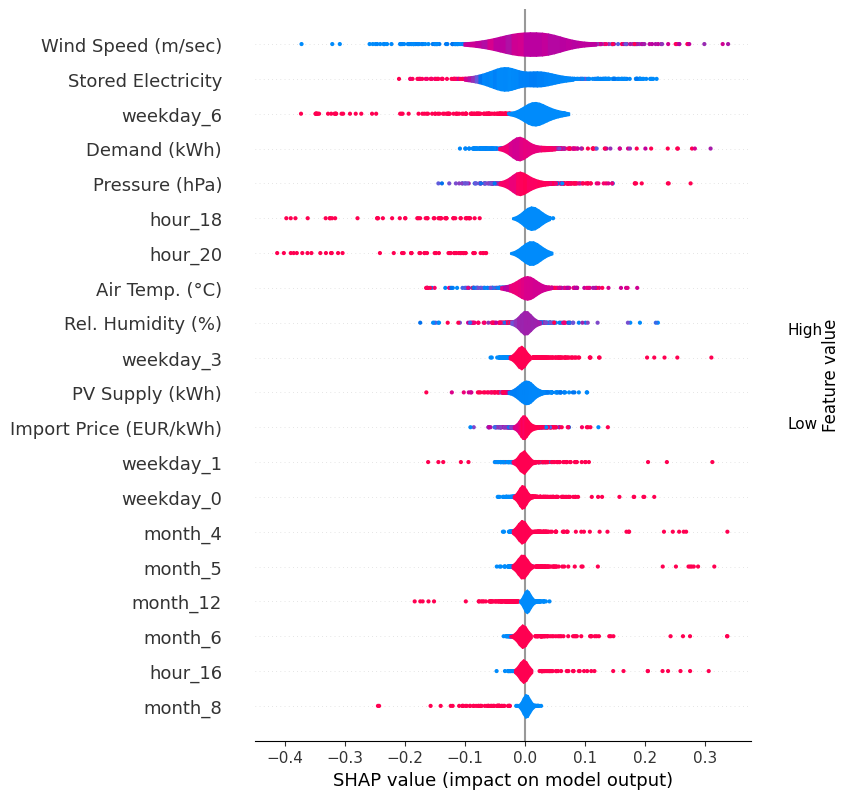

In [29]:
print_violin_plot(action_to_be_explained_index, np_shap_values, sample_df_2)

In [30]:
features_to_be_explained = ['Wind Speed (m/sec)', 'Stored Electricity', 'weekday_6', 'Demand (kWh)', 'Pressure (hPa)']

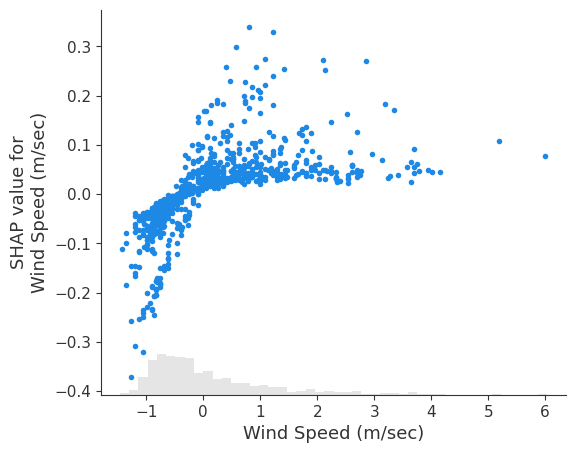

In [31]:
print_scatter_plot(action_to_be_explained_index, 0, np_shap_values, sample_df_2)

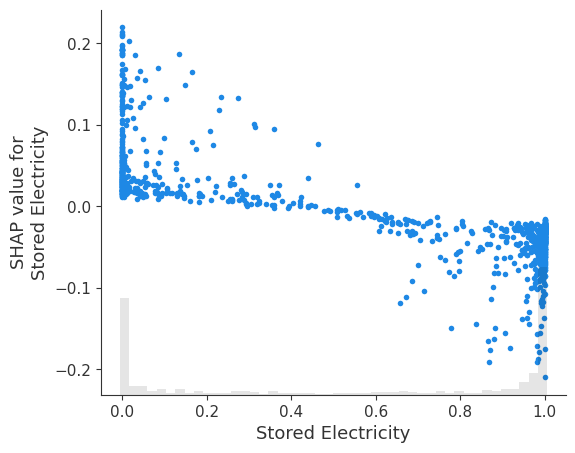

In [32]:
print_scatter_plot(action_to_be_explained_index, 1, np_shap_values, sample_df_2)

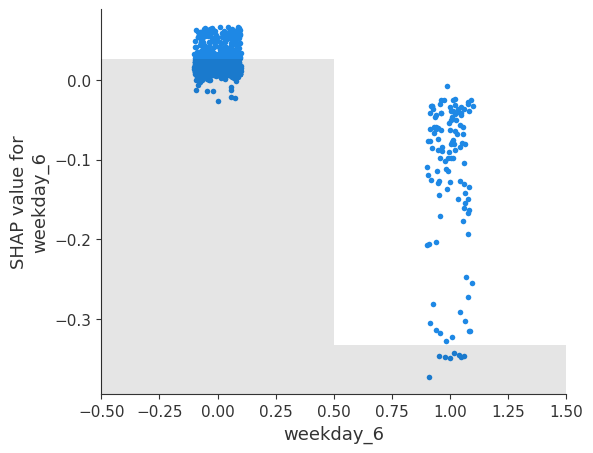

In [33]:
print_scatter_plot(action_to_be_explained_index, 2, np_shap_values, sample_df_2)

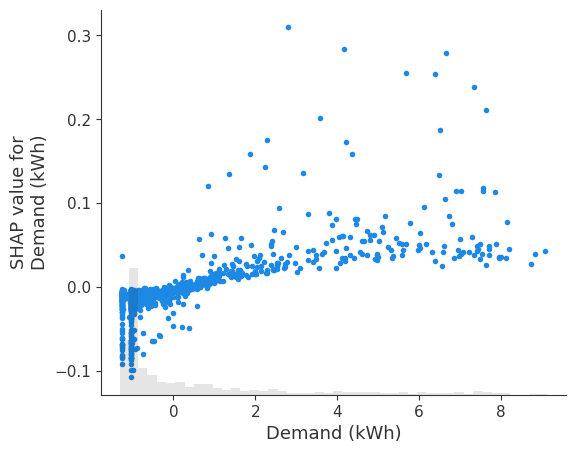

In [34]:
print_scatter_plot(action_to_be_explained_index, 3, np_shap_values, sample_df_2)

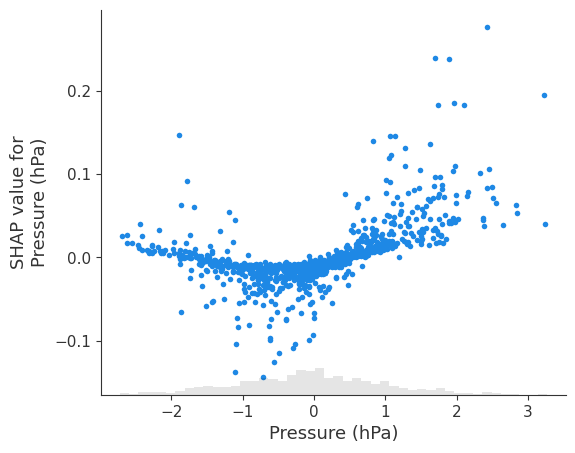

In [35]:
print_scatter_plot(action_to_be_explained_index, 4, np_shap_values, sample_df_2)

---

### Explaining Action 1: 
Higher values for this action mean, that the percentage of stored electricity used for covering the demand is higher.

Lower values for this action mean, that the percentage of stored electricity used for covering the demand is lower.

In [36]:
action_to_be_explained_index = 1

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


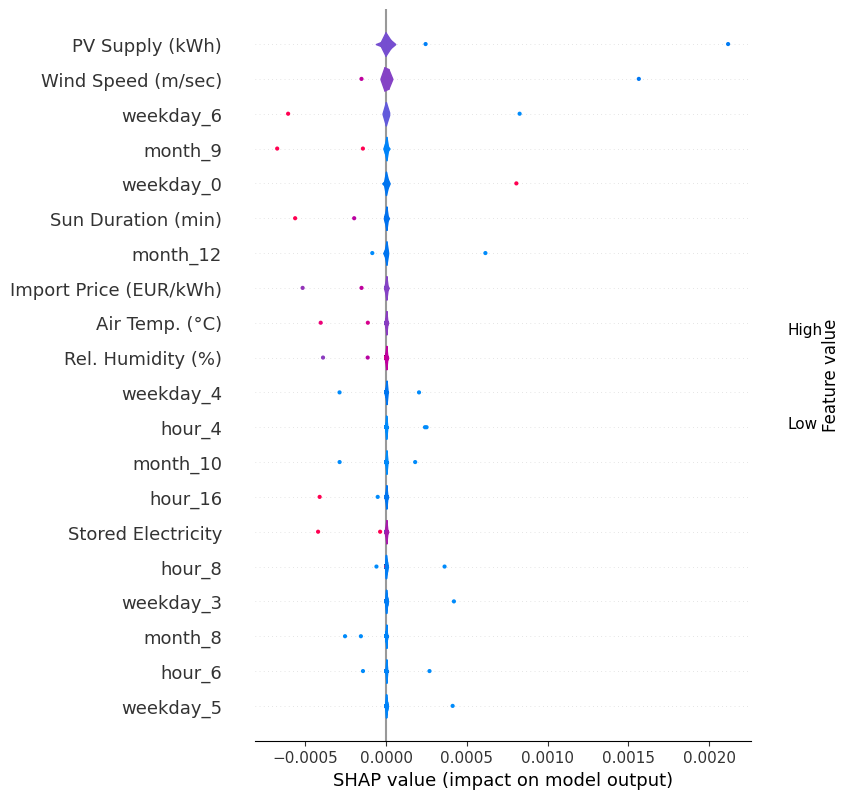

In [37]:
print_violin_plot(action_to_be_explained_index, np_shap_values, sample_df_2)

In [38]:
features_to_be_explained = ['PV Supply (kWh)', 'Wind Speed (m/sec)', 'weekday_6', 'month_9', 'weekday_0']

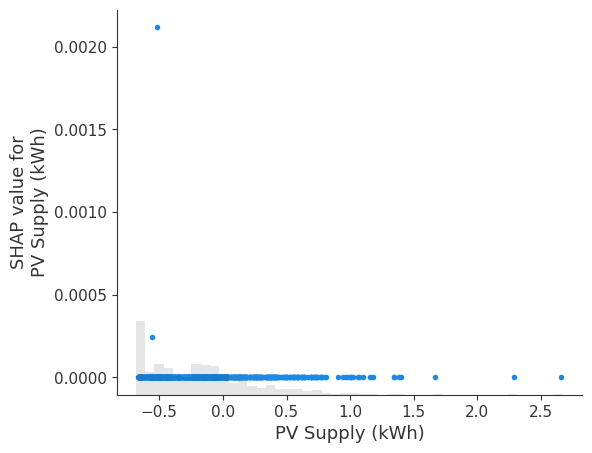

In [39]:
print_scatter_plot(action_to_be_explained_index, 0, np_shap_values, sample_df_2)

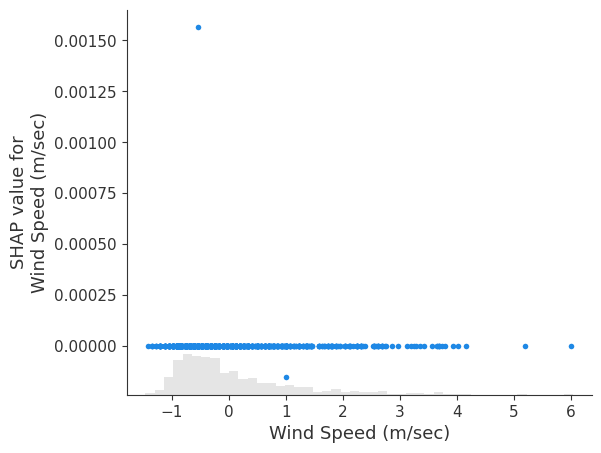

In [40]:
print_scatter_plot(action_to_be_explained_index, 1, np_shap_values, sample_df_2)

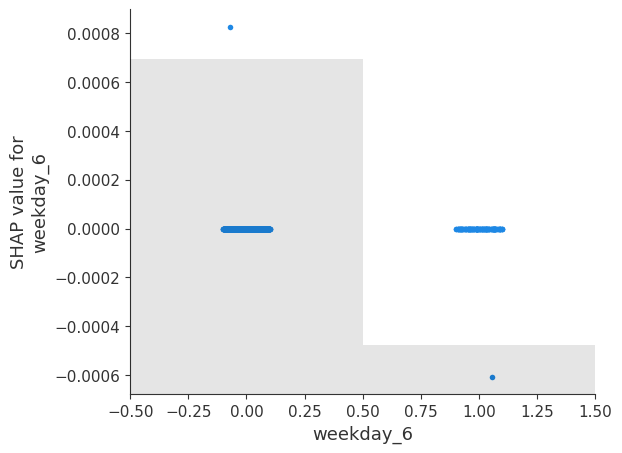

In [41]:
print_scatter_plot(action_to_be_explained_index, 2, np_shap_values, sample_df_2)

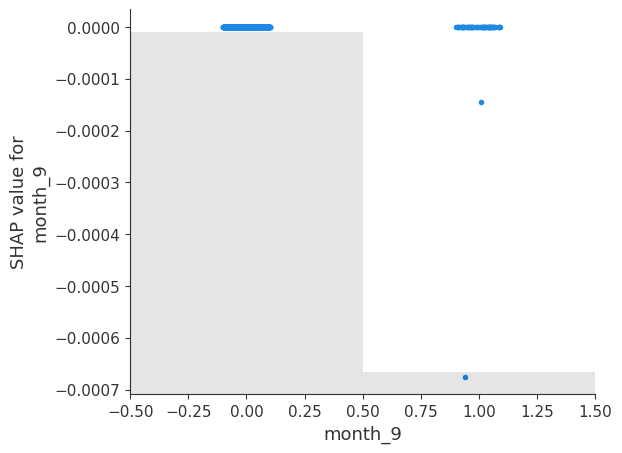

In [42]:
print_scatter_plot(action_to_be_explained_index, 3, np_shap_values, sample_df_2)

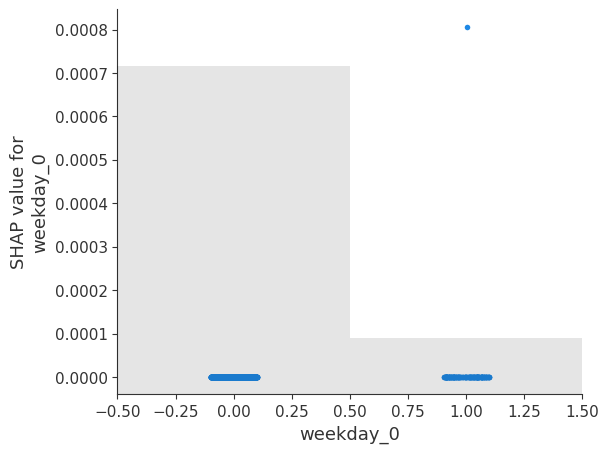

In [43]:
print_scatter_plot(action_to_be_explained_index, 4, np_shap_values, sample_df_2)

---

### Explaining Action 2: 
Higher values for this action mean, that the percentage of free storage capacity, filled via PV supply, is higher.

Lower values for this action mean, that the percentage of of free storage capacity, filled via PV supply, is lower.

In [44]:
action_to_be_explained_index = 2

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


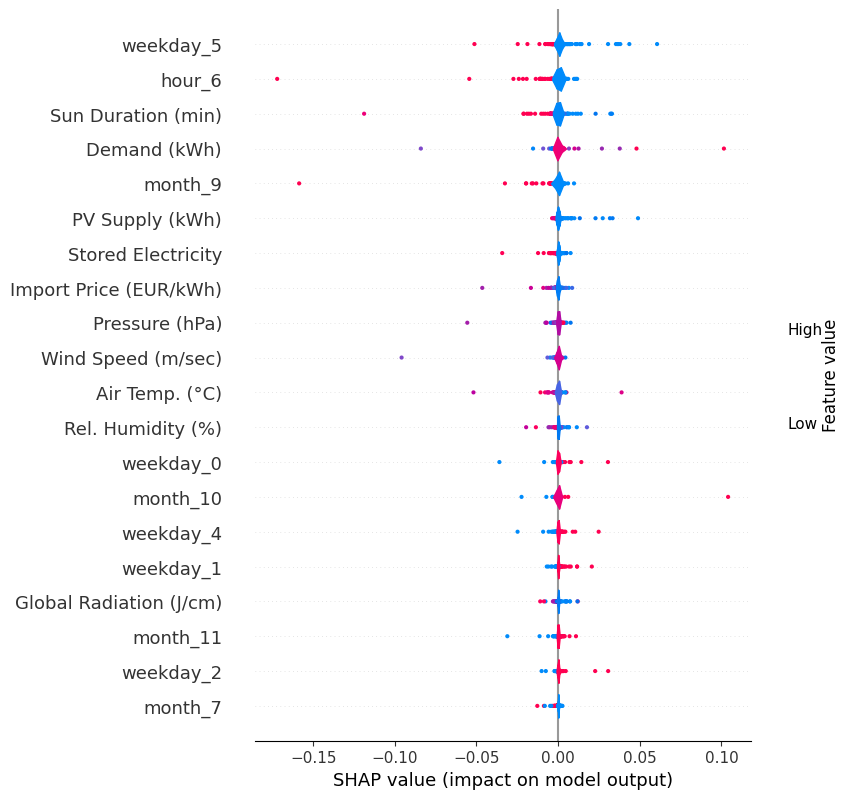

In [45]:
print_violin_plot(action_to_be_explained_index, np_shap_values, sample_df_2)

In [46]:
features_to_be_explained = ['weekday_5', 'hour_6', 'Sun Duration (min)', 'Demand (kWh)', 'month_9']

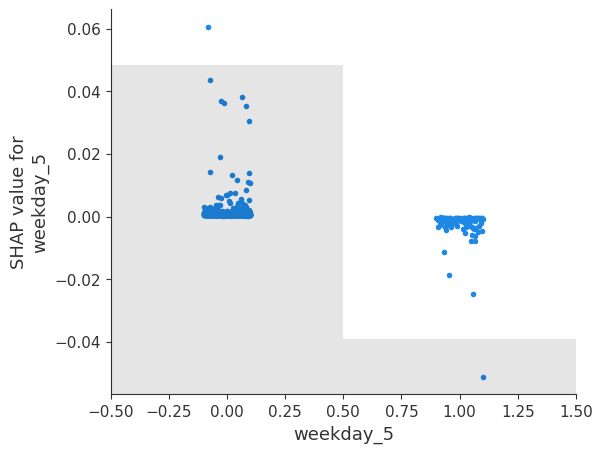

In [47]:
print_scatter_plot(action_to_be_explained_index, 0, np_shap_values, sample_df_2)

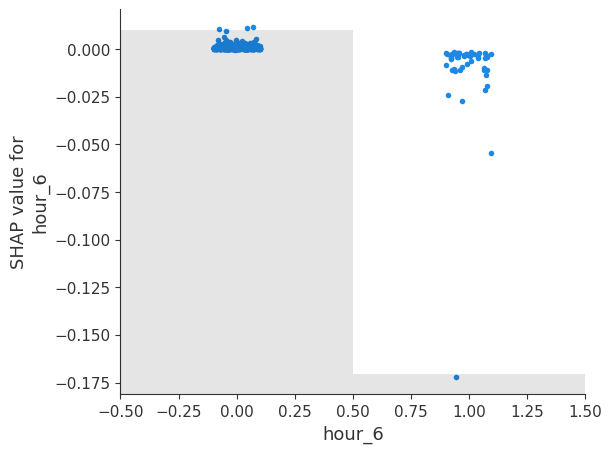

In [48]:
print_scatter_plot(action_to_be_explained_index, 1, np_shap_values, sample_df_2)

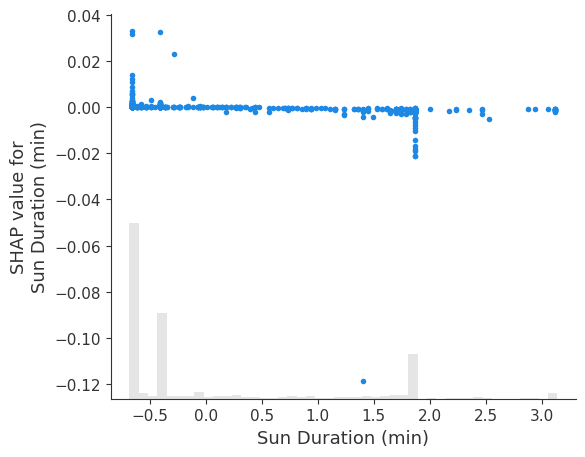

In [49]:
print_scatter_plot(action_to_be_explained_index, 2, np_shap_values, sample_df_2)

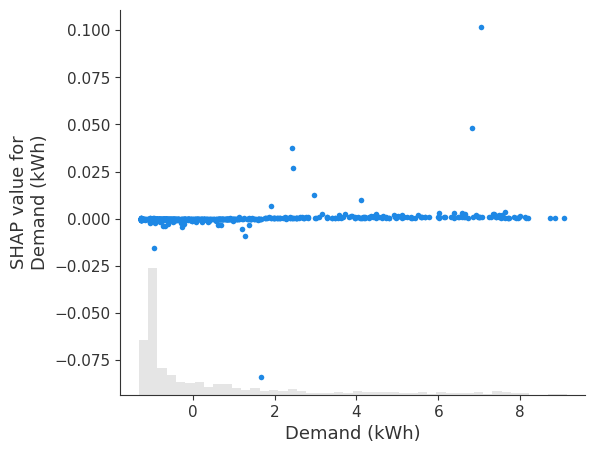

In [50]:
print_scatter_plot(action_to_be_explained_index, 3, np_shap_values, sample_df_2)

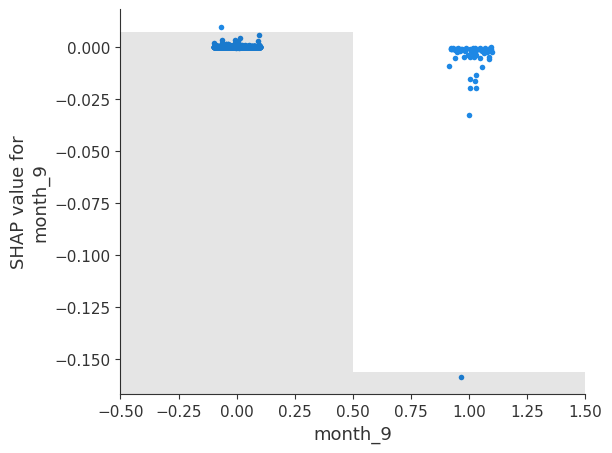

In [51]:
print_scatter_plot(action_to_be_explained_index, 4, np_shap_values, sample_df_2)

---

### Explaining Action 3: 
Higher values for this action mean, that the percentage of stored electricity sold into the grid is higher.

Lower values for this action mean, that the percentage of stored electricity sold into the grid  is lower.

In [52]:
action_to_be_explained_index = 3

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


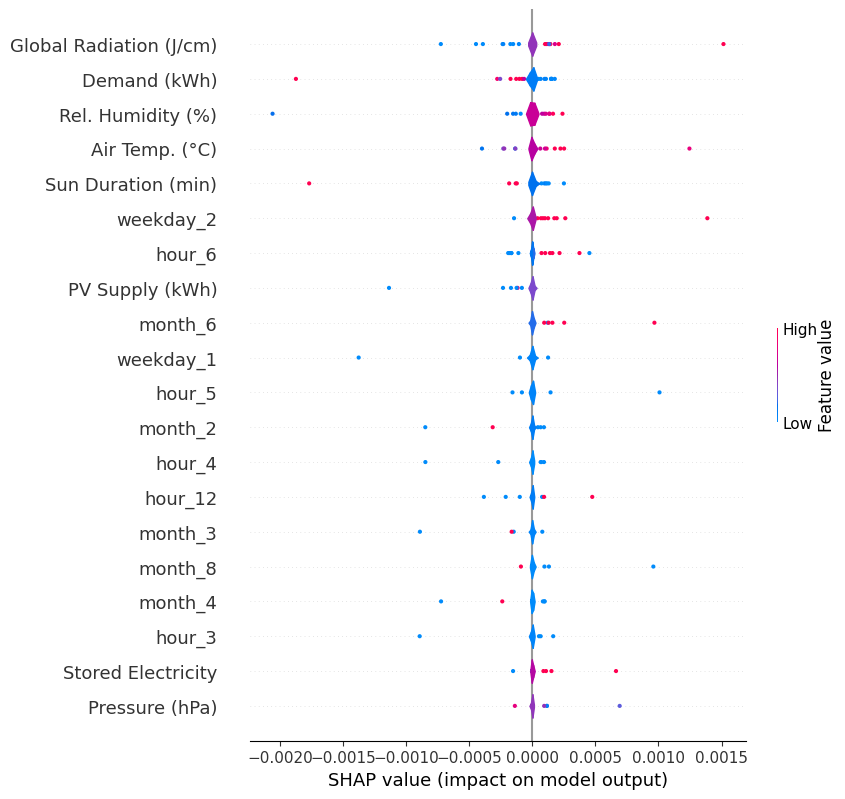

In [68]:
print_violin_plot(action_to_be_explained_index, np_shap_values, sample_df_2)

In [54]:
features_to_be_explained = ['Global Radiation (J/cm)', 'Demand (kWh)', 'Rel. Humidity (%)', 'Air Temp. (°C)', 'Sun Duration (min)']

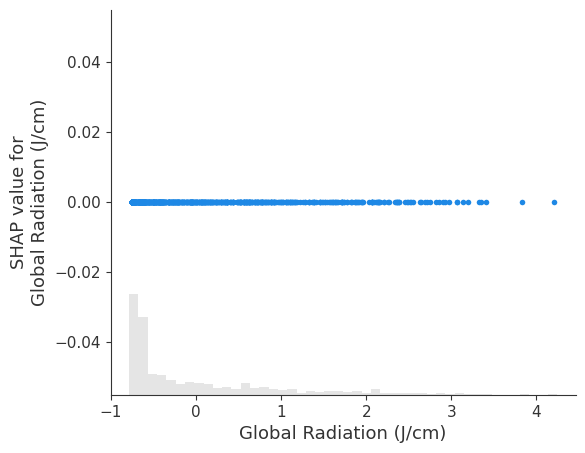

In [55]:
print_scatter_plot(action_to_be_explained_index, 0, np_shap_values, sample_df_2)

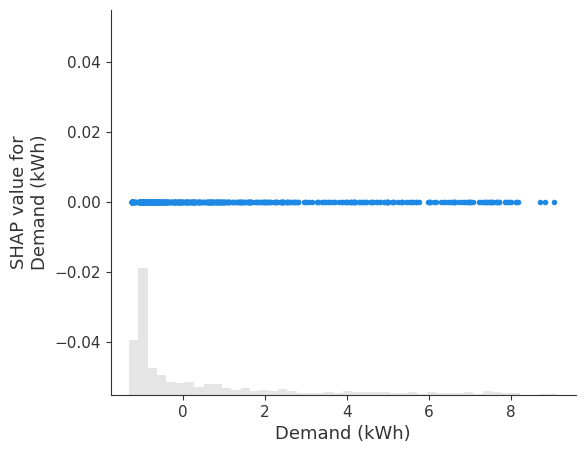

In [56]:
print_scatter_plot(action_to_be_explained_index, 1, np_shap_values, sample_df_2)

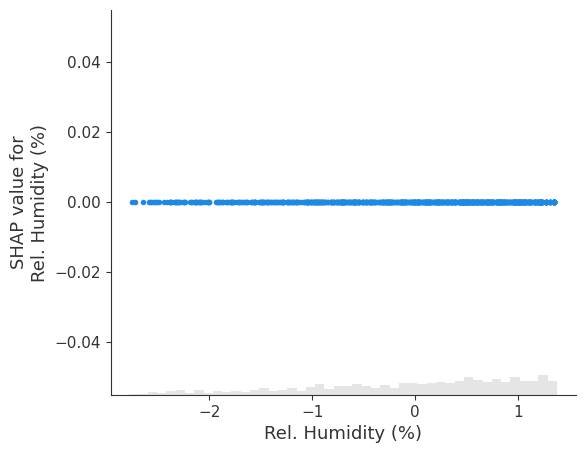

In [57]:
print_scatter_plot(action_to_be_explained_index, 2, np_shap_values, sample_df_2)

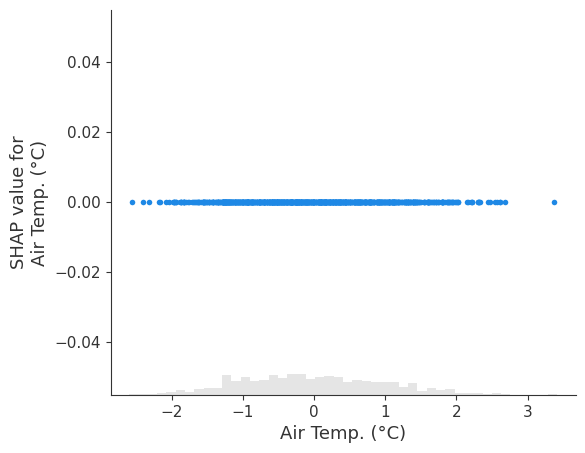

In [58]:
print_scatter_plot(action_to_be_explained_index, 3, np_shap_values, sample_df_2)

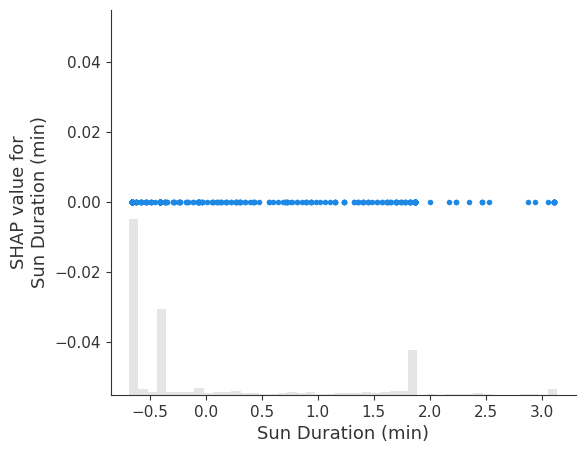

In [59]:
print_scatter_plot(action_to_be_explained_index, 4, np_shap_values, sample_df_2)

---

### Explaining Action 4: 
Higher values for this action mean, that the percentage of free storage capacity, filled via the grid, is higher.

Lower values for this action mean, that the percentage of free storage capacity, filled via the grid, is lower.

In [60]:
action_to_be_explained_index = 4

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


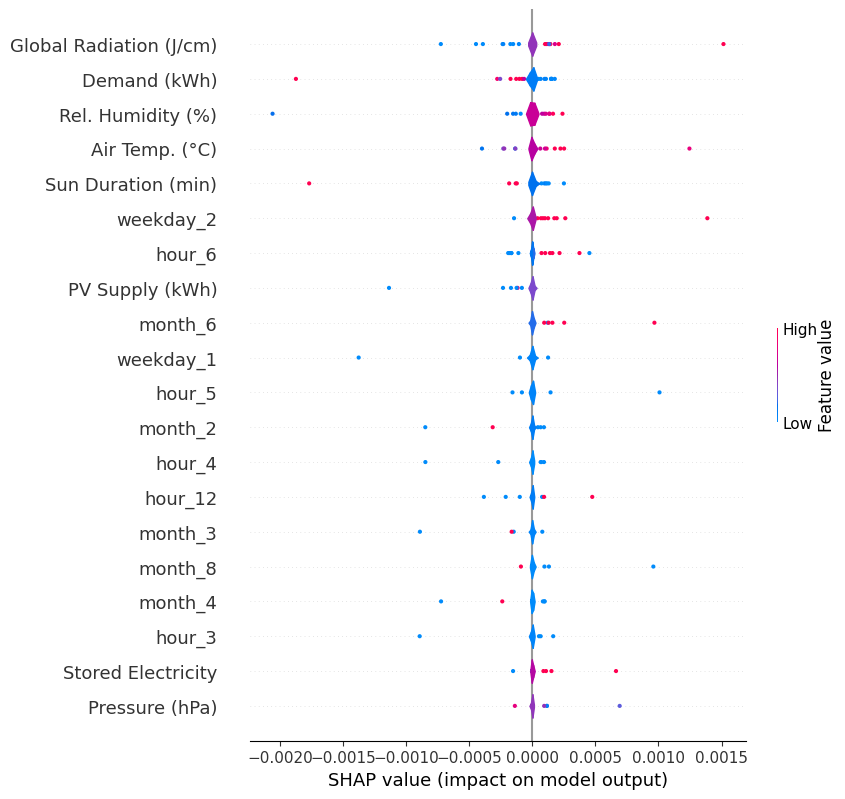

In [61]:
print_violin_plot(action_to_be_explained_index, np_shap_values, sample_df_2)

In [62]:
features_to_be_explained = ['Global Radiation (J/cm)', 'Demand (kWh)', 'Rel. Humidity (%)', 'Air Temp. (°C)', 'Sun Duration (min)']

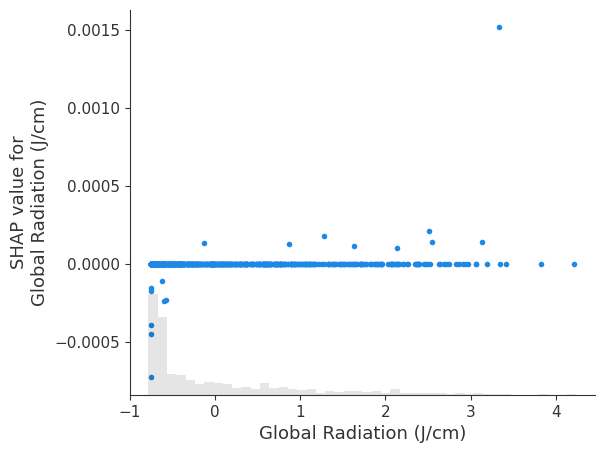

In [63]:
print_scatter_plot(action_to_be_explained_index, 0, np_shap_values, sample_df_2)

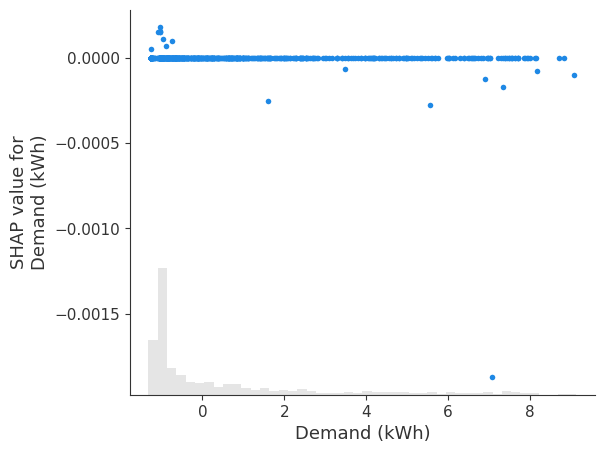

In [64]:
print_scatter_plot(action_to_be_explained_index, 1, np_shap_values, sample_df_2)

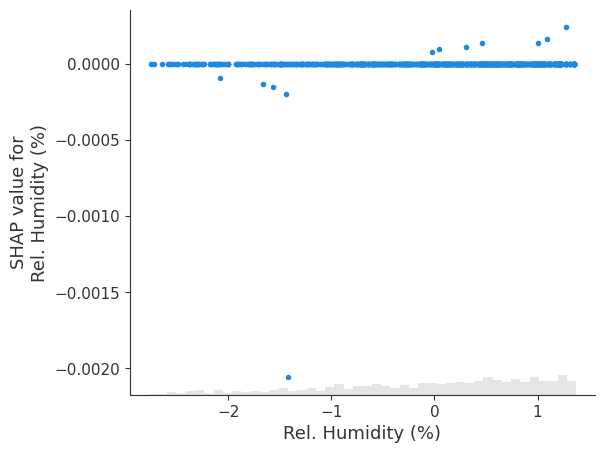

In [65]:
print_scatter_plot(action_to_be_explained_index, 2, np_shap_values, sample_df_2)

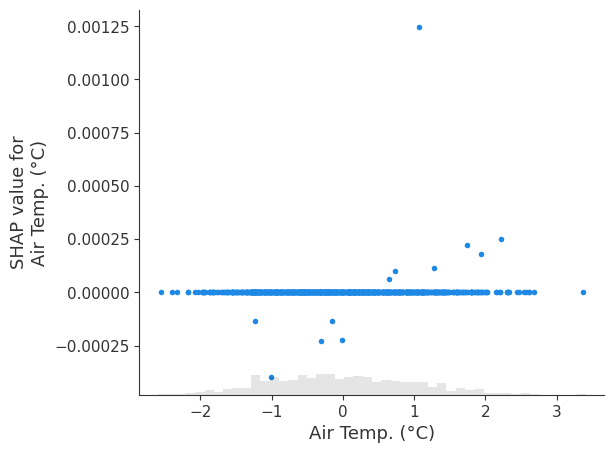

In [66]:
print_scatter_plot(action_to_be_explained_index, 3, np_shap_values, sample_df_2)

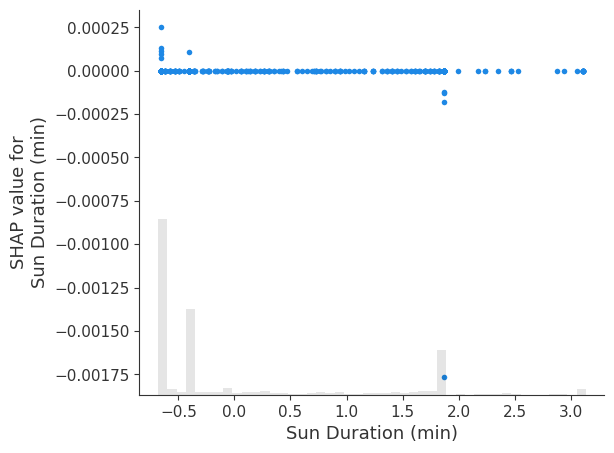

In [67]:
print_scatter_plot(action_to_be_explained_index, 4, np_shap_values, sample_df_2)